# Use bloomberg download data to get me started

In [725]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from textwrap import wrap
%matplotlib inline

In [2]:
#initial cleaning function
def clean_sheet(dataframe):
    adj=dataframe.dropna(axis=1,how='all')
    adj=dataframe.set_index(adj.columns[0]) #use stock tickers as the index
    return adj

In [622]:
#pull the data from excel, form a dictionary of tab names and dataframes
tabs_to_grab=['Quarter','Date','Revision','Market cap','Volume','Property']

data_dict={}

for s in tabs_to_grab:
    df=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\Europe 2007-2018.xlsx',sheet_name=s))
    data_dict[s]=df.dropna(axis=0,how='all')

In [4]:
# get the price dataframe for certain years; form the price and return datetime from the data from all the years 
def return_from_excel(path, start_year,end_year):
    
    year_range=range(start_year,end_year+1)

    price_list=[]
    rel_price_list=[]
    abs_return_list=[]
    rel_return_list=[]
    for year in year_range:
        price_year=clean_sheet(pd.read_excel(path,sheet_name=str(year))).dropna(how='all',axis=0)
        rel_price=price_year/price_year.loc["SXXP Index"]
        rel_price=rel_price.dropna(how='all',axis=0)
        abs_return=price_year.diff(1,axis=1)/price_year.shift(1,axis=1)
        abs_return=abs_return.dropna(how='all',axis=0)
        rel_return=abs_return - abs_return.loc["SXXP Index"]
        rel_return=rel_return.dropna(how='all',axis=0)
        price_list.append(price_year)
        rel_price_list.append(rel_price)
        abs_return_list.append(abs_return)
        rel_return_list.append(rel_return)

    price=pd.concat(price_list,axis=1).dropna(axis=1,how='all').dropna(axis=0,how='all')
    rel_price=pd.concat(rel_price_list,axis=1).dropna(axis=1,how='all').dropna(axis=0,how='all')
    abs_return=pd.concat(abs_return_list,axis=1).dropna(axis=1,how='all').dropna(axis=0,how='all')
    rel_return=pd.concat(rel_return_list,axis=1).dropna(axis=1,how='all').dropna(axis=0,how='all')

    # transform the datetime to the common timestamp format
    price_column=[i.strftime("%d/%b/%Y") for i in price.columns.tolist() if type(i)!=str]
    rel_price_column=[i.strftime("%d/%b/%Y") for i in rel_price.columns.tolist() if type(i)!=str]
    abs_return_column=[i.strftime("%d/%b/%Y") for i in abs_return.columns.tolist() if type(i)!=str]
    rel_return_column=[i.strftime("%d/%b/%Y") for i in rel_return.columns.tolist() if type(i)!=str]

    price.columns=price_column
    rel_price.columns=rel_price_column
    abs_return.columns=abs_return_column
    rel_return.columns=rel_return_column
    
    return price, rel_price, abs_return,rel_return 


price,rel_price,abs_return,rel_return=return_from_excel(r'C:\Users\Eric.Li\Documents\Post result data\Europe price.xlsx', 2007,2018)

In [5]:
# utility function to get volatility from return series
def vol_calc(return_series, vol_lookback):
    hist=len(return_series)
    if hist<=vol_lookback:
        vol=return_series[-hist+1:].std()
    else:
        vol=return_series[-vol_lookback-1:-1].std()
    return vol

In [6]:
# utility function to obtain announcement return (as a multiplier of vol) as a result of day 0 and return dataframe
def ann_ret(single_date,return_series,EAR_period,vol_lookback):
    if type(single_date)==pd._libs.tslib.Timestamp:
        date_series=return_series.index.tolist()
        if single_date.strftime("%d/%b/%Y") in date_series:
            day0=date_series.index(single_date.strftime("%d/%b/%Y"))
            vol=vol_calc(return_series,vol_lookback)
            if len(return_series.iloc[day0:])<EAR_period:
                ret=return_series[day0:].sum()
                nmove=ret/vol
            else:
                ret=return_series.iloc[day0:day0+EAR_period].sum()
                nmove=ret/vol
            return nmove
        else:
            return None
    else:
        return single_date

In [7]:
# obtain the announcement return dataframe from price return and date dataframe
def EAR(date_df,return_df,EAR_period,vol_lookback):
    EAR_list=[]
    for ticker, date_row in date_df.iterrows():
        if type(ticker)==str: #deal with 
            return_row=return_df.loc[ticker]
            ret_series=date_row.apply(lambda x: ann_ret(x,return_row,EAR_period,vol_lookback))
            EAR_list.append(ret_series)
        else:
            pass
    EAR_df=pd.concat(EAR_list,axis=1).T
    return EAR_df

## Signal 1 - absolute signal

In [157]:
#signal formation (number 1) and use the date as the base dataframe
def signal1_formation(date_df,return_df,EAR_period,vol_lookback,return_criteria,revision_df, revision_criteria):
    EAR_return=EAR(date_df,return_df,EAR_period,vol_lookback).fillna(0.0).loc[revision_df.index.tolist()]
    signal1_evaluate=(EAR_return>return_criteria) & (revision_df>revision_criteria)
    signal1=date_df[signal1_evaluate]
    signal1_next=date_df.shift(1,axis=1)[signal1_evaluate]
    return signal1,signal1_next

signal1,signal1_next=signal1_formation(data_dict['Date'],rel_return,3,30,2,data_dict['Revision'],0.02)

In [351]:
#Stack signals into a list of tuples (stocks, dates,next earnign dates, next signal dates), convert dates into a common format of datetime
def signal1_stacking(signal1,signal1_next):
    signal1_list=[]
    for ticker, row in signal1.iterrows():
        adj_row=row.dropna()
        for idx in range(len(row)):
            date=row.iloc[idx]
            date_next=signal1_next.loc[ticker].iloc[idx]
            if type(date)==pd._libs.tslib.Timestamp:
                adj_date=date.strftime("%d/%b/%Y") #transform the datetime into a common format
                loc_date=adj_row.tolist().index(date)
                if (loc_date>0)&(len(adj_row)>0):
                    next_signal=adj_row.iloc[loc_date-1].strftime("%d/%b/%Y") 
                    adj_next_date=date_next.strftime("%d/%b/%Y") 
                elif type(date_next)==pd._libs.tslib.Timestamp:
                    next_signal=None
                    adj_next_date=date_next.strftime("%d/%b/%Y") 
                else:
                    next_signal=None
                    adj_next_date=None                
                signal1_list.append((row.name,adj_date,adj_next_date,next_signal))
            else:
                pass
    return signal1_list

In [353]:
# create a dictionary to have signal information (tuple) as keys and return data time series as values to make it easier to check
#; replace datetime with number of days post announcement to make it more comparable 
def signal1_dict_day(signal1_list,return_df,holding,earning):#if we hold them through next earning
    signal1_dict={}
    for s in signal1_list:
        return_series=return_df.loc[s[0]]
        if s[1] in return_series.index:          
            day0=return_series.index.tolist().index(s[1]) #index of day 0
            if earning is True:
                period=holding
            elif type(s[2])==pd._libs.tslib.NaTType:
                period=holding
            else:
                period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[2],"%d/%b/%Y")))
            target_series=return_series.iloc[day0:day0+min(period, len(return_series[day0:]))]
            target_series.index=range(min(period, len(return_series[day0:]))) #replace datetime with number of days post announcement
            target_series.name=(s[0],s[1])
            signal1_dict[s]=target_series
        else:
            pass          
    return signal1_dict

In [493]:
# obtain the dataframe of return time series for the signal stocks, take the signal_return_dict function
def signal1_df_day(signal1,signal1_next,return_df,holding,earning,entry):
    return_series_list=[]
    return_dict=signal1_dict_day(signal1_stacking(signal1,signal1_next),return_df,holding,earning)
    for index,key in return_dict.items():
        return_series_list.append(key)
    try:
        signal1_df=pd.concat(return_series_list,axis=1)
        if earning is True:
            signal1_df=signal1_df.dropna(how='any',axis=1) #drop stocks with limited history to make it more comparable
        else:
            signal1_df=signal1_df.dropna(how='all',axis=1).dropna(how='all',axis=0)
        return signal1_df[entry:]
    except ValueError:
        return None

In [494]:
## obtain the resulting signal dataframe with return series
signal1_abs_df=signal1_df_day(signal1,signal1_next,abs_return,130,True,3)
signal1_rel_df=signal1_df_day(signal1,signal1_next,rel_return,130,True,3)

# List of signals and cumulative returns
signal1_list_abs=((1+signal1_abs_df).cumprod(axis=0)-1).iloc[-1]
signal1_list_abs

signal1_list_rel=((1+signal1_rel_df).cumprod(axis=0)-1).iloc[-1]
signal1_list_rel.sort_values()

US IM      10/May/2012   -0.676089
UNI IM     15/Mar/2012   -0.644189
TOM2 NA    24/Oct/2007   -0.580796
SWEDA SS   17/Jul/2008   -0.571287
BOL SS     08/May/2008   -0.544891
BKT SM     19/Jan/2012   -0.532898
BOL SS     19/Jul/2007   -0.522603
YIT FH     25/Apr/2008   -0.514392
YAR NO     18/Apr/2008   -0.483122
NRE1V FH   07/May/2008   -0.482524
OTE1V FH   23/Apr/2008   -0.481260
SDF GR     14/Mar/2013   -0.468914
SUBC NO    31/Jul/2014   -0.451361
NOKIA FH   20/Oct/2011   -0.447627
KBC BB     12/May/2011   -0.438769
SSABB SS   23/Jul/2014   -0.438320
SSABA SS   23/Jul/2014   -0.432210
NHY NO     22/Apr/2008   -0.424918
MTGB SS    22/Jul/2008   -0.418317
BEKB BB    25/Feb/2011   -0.417369
MT NA      30/Jul/2008   -0.413892
BOKA NA    21/Aug/2008   -0.403549
UG FP      23/Jul/2008   -0.400976
EBS AV     30/Apr/2008   -0.395726
AF FP      18/Feb/2016   -0.395645
ELUXB SS   17/Jul/2007   -0.394837
AAL LN     25/Jul/2014   -0.382100
REN NA     19/Feb/2009   -0.379293
STERV FH   23/Oct/20

In [567]:
# Performance analytics
# 1. trading analytics
def trading_analytics_day(signal_df_day):
    ind_return=((1+signal_df_day).cumprod()-1).ffill().iloc[-1]
    signal1_count=len(ind_return)
    if signal1_count==0:
        return None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        return mean_return,signal1_count, hit_rate,payoff_ratio

In [14]:
# 2. aggregate abs/rel performance over time
def perf_chart_day(signal_df_day,xlabel,ylabel,title,figsize,quantile_list):
    quantile_columns=[str(int(i*100))+' percentile' for i in quantile_list]
    cum_return=((1+signal_df_day).cumprod()-1).ffill().mean(axis=1)
    perf_df=((1+signal_df_day).cumprod()-1).ffill().apply(lambda row: row.quantile(quantile_list),axis=1)
    perf_df.columns=quantile_columns
    perf_df["Mean"]=cum_return
    
    ax=perf_df.plot(figsize=figsize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    vals=ax.get_yticks()
    start=vals[0]
    end=vals[-1]
    ax.set_yticks(np.arange(start,end,0.05))  
    adj_vals=ax.get_yticks()
    ax.set_yticklabels(["{:.0%}".format(x) for x in adj_vals])
    
    mean_return,count,hit, payoff=trading_analytics_day(signal_df_day)
    
    plt.title('mean_return='+str("{:.1%}".format(mean_return)+
              ',count='+str(count)+
              ',hit rate='+str("{:.0%}".format(hit))+
              ',payoff='+str(round(payoff,2))),fontsize=10)
    
    plt.suptitle(title,fontsize=14)
    plt.legend(fontsize=8)
    plt.grid(linestyle='dashed')
    plt.axhline(y=0,color='k')

    plt.show()


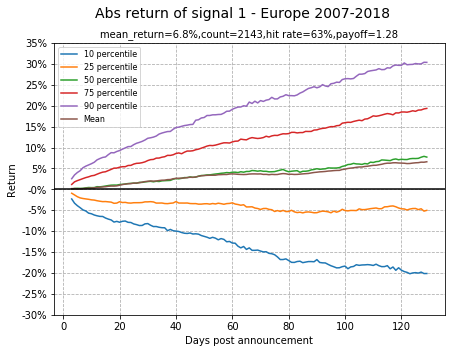

In [497]:
perf_chart_day(signal1_df_day(signal1,signal1_next,abs_return,130,True,3),"Days post announcement",
           "Return","Abs return of signal 1 - Europe 2007-2018",[7,5],
          [0.1,0.25,0.5,0.75,0.9])

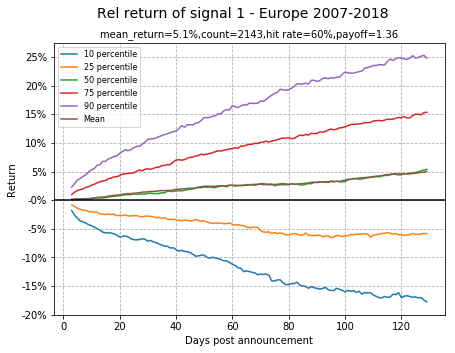

In [498]:
perf_chart_day(signal1_df_day(signal1,signal1_next,rel_return,130,True,3),"Days post announcement",
           "Return","Rel return of signal 1 - Europe 2007-2018",[7,5],
          [0.1,0.25,0.5,0.75,0.9])

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  if __name__ == '__main__':
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  


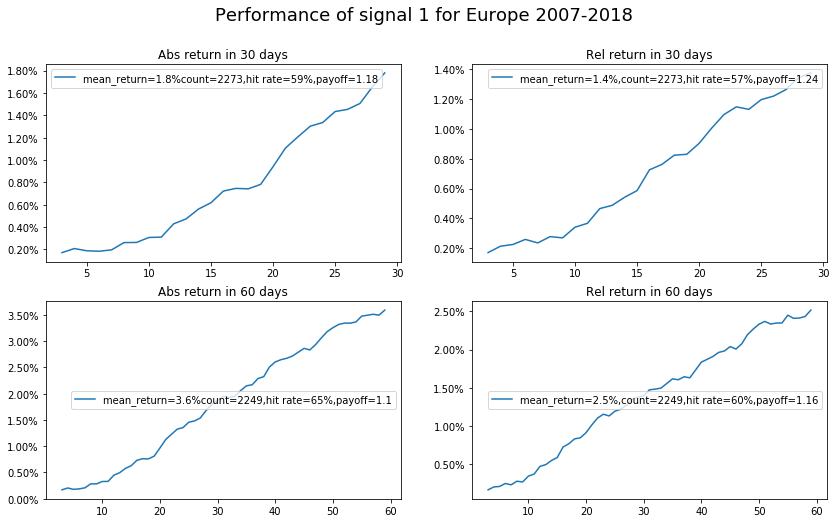

In [53]:
# plot the performance for different holding period 
def plot_by_holding(period_list,figsize,fontsize,title,signal1,signal1_next,abs_return,rel_return,earning,entry):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize)
    for idx, val in enumerate(period_list):
        ax1=fig.add_subplot(len(period_list),2,idx*2+1)
        abs_return_df=signal1_df_day(signal1,signal1_next,abs_return,val,earning,entry)
        abs_cum_return=(1+abs_return_df.mean(axis=1)).cumprod()-1
        ax1.plot(abs_cum_return)

        val1=ax1.get_yticks()
        ax1.set_yticklabels(["{:.2%}".format(x) for x in val1])
    
        ax1.set_title("Abs return in "+str(val)+" days")
        mean1,count1,hit1,payoff1=trading_analytics_day(abs_return_df)
        ax1.legend(['mean_return='+str("{:.1%}".format(mean1))+
                    'count='+str(count1)+
                    ',hit rate='+str("{:.0%}".format(hit1))+
                    ',payoff='+str(round(payoff1,2))])

        ax2=fig.add_subplot(len(period_list),2,idx*2+2)
        rel_return_df=signal1_df_day(signal1,signal1_next,rel_return,val,earning,entry)
        rel_cum_return=(1+rel_return_df.mean(axis=1)).cumprod()-1
        ax2.plot(rel_cum_return)
        
        val2=ax2.get_yticks()
        ax2.set_yticklabels(["{:.2%}".format(x) for x in val2])
        
        ax2.set_title("Rel return in "+str(val)+" days")
        mean2,count2,hit2,payoff2=trading_analytics_day(rel_return_df)
        ax2.legend(['mean_return='+str("{:.1%}".format(mean2))+
                    ',count='+str(count2)+
                    ',hit rate='+str("{:.0%}".format(hit2))+
                    ',payoff='+str(round(payoff2,2))],loc='best')
    plt.show()

    
plot_by_holding([30,60],(14,8),18,"Performance of signal 1 for Europe 2007-2018",signal1,signal1_next,abs_return,rel_return,True,3)

## Signal performance by years

In [564]:
# plot the performance for different year
def plot_by_year(start_year,end_year,figsize,fontsize,title,signal1_abs_df,signal1_rel_df):    
    year_range=range(start_year,end_year+1)
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title,y=0.9, fontsize=fontsize)
    for idx, val in enumerate(year_range):
        ax1=fig.add_subplot(len(year_range),2,idx*2+1)
        signal1_abs_year=signal1_abs_df.loc[:,signal1_abs_df.apply(lambda x: 
                                                                       (pd.Timestamp(datetime.strptime(x.name[1],"%d/%b/%Y"))>=pd.Timestamp(val,1,1))
                                                                       &(pd.Timestamp(datetime.strptime(x.name[1],"%d/%b/%Y"))<=pd.Timestamp(val,12,31)))]
        signal1_abs_cum=((1+signal1_abs_year).cumprod()-1).ffill().mean(axis=1)
        ax1.plot(signal1_abs_cum)
        ax1.set_title("Abs return in "+str(val))
        try:
            mean_return,count,hit,payoff=trading_analytics_day(signal1_abs_year)
            ax1.legend(['mean_return='+str("{:.1%}".format(mean_return))+
                        ',count='+str(count)+
                        ',hit rate='+str("{:.0%}".format(hit))+
                        ',payoff='+str(round(payoff,2))])
        except:
            pass

        ax2=fig.add_subplot(len(year_range),2,idx*2+2)
        signal1_rel_year=signal1_rel_df.loc[:,signal1_rel_df.apply(lambda x: 
                                                                       (pd.Timestamp(datetime.strptime(x.name[1],"%d/%b/%Y"))>=pd.Timestamp(val,1,1))
                                                                       &(pd.Timestamp(datetime.strptime(x.name[1],"%d/%b/%Y"))<=pd.Timestamp(val,12,31)))]
        signal1_rel_cum=((1+signal1_rel_year).cumprod()-1).ffill().mean(axis=1)
        ax2.plot(signal1_rel_cum)
        ax2.set_title("Rel return in "+str(val))
        try:
            mean_return,count,hit,payoff=trading_analytics_day(signal1_rel_year)
            ax2.legend(['mean_return='+str("{:.1%}".format(mean_return))+
                        ',count='+str(count)+
                        ',hit rate='+str("{:.0%}".format(hit))+
                        ',payoff='+str(round(payoff,2))])
        except:
            pass

    plt.show()


In [ ]:
plot_by_year(2007, 2017,(15,40),20,
             "Performance of signal 1 for Europe 2007-2018",signal1_abs_df,signal1_rel_df)

## by sector

In [ ]:
## sector mapping and unique sector list, add the sector column to the signal
def sector_mapping(ticker,mapping_df):
    mapping=mapping_df.dropna()
    if ticker in mapping.index:
        sector=mapping[ticker]
    else:
        sector=None
    return sector
    
unique_sector=list(set(data_dict["Property"]["Sector"].dropna().values))
signal1_with_sector=signal1.copy()
signal1_next_with_sector=signal1_next.copy()
signal1_with_sector["sector"]=[sector_mapping(i,data_dict["Property"]["Sector"]) for i in signal1_with_sector.index]
signal1_next_with_sector["sector"]=[sector_mapping(i,data_dict["Property"]["Sector"]) for i in signal1_next_with_sector.index]

In [ ]:
# plot the performance for different sectors
def plot_by_sector(sector_list,figsize,fontsize,title,signal1,signal1_next,abs_return,rel_return,holding_period,earning,entry):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize)
    for idx, sector in enumerate(sector_list):
        signal1_sector=signal1[signal1["sector"]==sector].iloc[:,:-1]
        signal1_next_sector=signal1_next[signal1_next["sector"]==sector].iloc[:,:-1]
        
        ax1=fig.add_subplot(len(sector_list),2,idx*2+1)
        abs_return_df=signal1_df_day(signal1_sector,signal1_next_sector,abs_return,holding_period,earning,entry)
        abs_cum_return=(1+abs_return_df.mean(axis=1)).cumprod()-1
        ax1.plot(abs_cum_return)
        ax1.set_title("Abs return in "+str(sector))
        count,hit, payoff=trading_analytics_day(abs_return_df)
        ax1.legend(['count='+str(count)+
                    ',hit rate='+str("{:.0%}".format(hit))+
                    ',payoff='+str(round(payoff,2))])

        ax2=fig.add_subplot(len(sector_list),2,idx*2+2)
        rel_return_df=signal1_df_day(signal1_sector,signal1_next_sector,rel_return,holding_period,earning,entry)
        rel_cum_return=(1+rel_return_df.mean(axis=1)).cumprod()-1
        ax2.plot(rel_cum_return)
        ax2.set_title("Rel return in "+str(sector))
        count,hit, payoff=trading_analytics_day(rel_return_df)
        ax2.legend(['count='+str(count)+
                    ',hit rate='+str("{:.0%}".format(hit))+
                    ',payoff='+str(round(payoff,2))])
    
    plt.show()

In [ ]:
plot_by_sector(unique_sector,(15,60),18,
             "Performance of signal 1 for Europe 2007-2018",signal1_with_sector,signal1_next_with_sector,abs_return,rel_return, 120,True,3)

## Signal performance by country

In [ ]:
## unique country list, add the country column to the signal
signal1_with_country=signal1.copy()
signal1_with_country["country"]=[i[-2:] for i in signal1_with_country.index]
signal1_next_with_country=signal1_next.copy()
signal1_next_with_country["country"]=[i[-2:] for i in signal1_next_with_country.index]

unique_country=list(set(signal1_with_country["country"]))

In [565]:
# plot the performance by countries
def plot_by_country(country_list,figsize,fontsize,title,signal1,signal1_next,abs_return,rel_return,holding_period,earning,entry):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize)
    for idx, country in enumerate(country_list):
        signal1_country=signal1[signal1["country"]==country].iloc[:,:-1]
        signal1_next_country=signal1_next[signal1_next["country"]==country].iloc[:,:-1]
        
        ax1=fig.add_subplot(len(country_list),2,idx*2+1)
        #print(signal1_country,signal1_next_country)
        abs_return_df=signal1_df_day(signal1_country,signal1_next_country,abs_return,holding_period,earning,entry)
        if abs_return_df is not None:
            abs_cum_return=(1+abs_return_df.mean(axis=1)).cumprod()-1
            ax1.plot(abs_cum_return)
            ax1.set_title("Abs return in "+str(country))
            count,hit, payoff=trading_analytics_day(abs_return_df)
            ax1.legend(['count='+str(count)+
                        ',hit rate='+str("{:.0%}".format(hit))+
                        ',payoff='+str(round(payoff,2))])
        else:
            pass
        
        ax2=fig.add_subplot(len(country_list),2,idx*2+2)
        rel_return_df=signal1_df_day(signal1_country,signal1_next_country,rel_return,holding_period,earning,entry)
        if rel_return_df is not None:  
            rel_cum_return=(1+rel_return_df.mean(axis=1)).cumprod()-1
            ax2.plot(rel_cum_return)
            ax2.set_title("Rel return in "+str(country))
            count,hit, payoff=trading_analytics_day(rel_return_df)
            ax2.legend(['count='+str(count)+
                        ',hit rate='+str("{:.0%}".format(hit))+
                        ',payoff='+str(round(payoff,2))])
        else:
            pass
    plt.show()

In [ ]:
plot_by_country(unique_country,(15,50),18,
             "Performance of signal 1 for Europe 2007-2018",signal1_with_country,signal1_next_with_country,abs_return,rel_return, 120,True,3)

## Avoid holding through numbers

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  if __name__ == '__main__':
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  


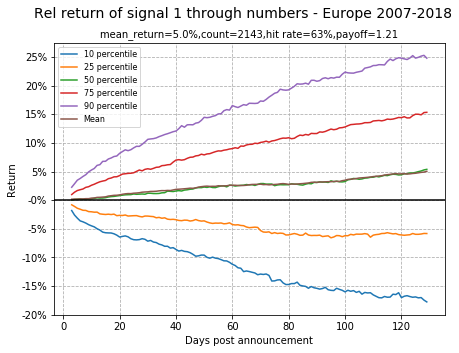

In [22]:
# Hold through numbers
perf_chart_day(signal1_df_day(signal1,signal1_next,rel_return,130,True,3),"Days post announcement",
           "Return","Rel return of signal 1 through numbers - Europe 2007-2018",[7,5],
          [0.1,0.25,0.5,0.75,0.9])

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  if __name__ == '__main__':
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  


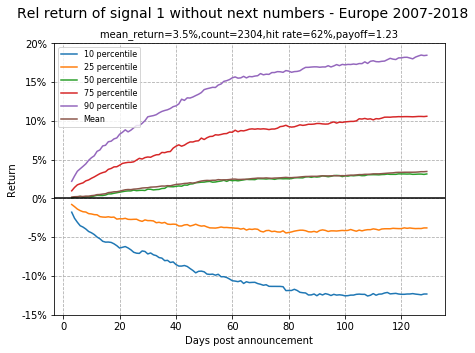

In [24]:
# Not through numbers
perf_chart_day(signal1_df_day(signal1,signal1_next,rel_return,130,False,3),"Days post announcement",
           "Return","Rel return of signal 1 without next numbers - Europe 2007-2018",[7,5],
          [0.1,0.25,0.5,0.75,0.9])

## Impact of size on the profit


In [501]:
## grab market cap data
market_cap=data_dict["Market cap"]

## function to grab market cap
def get_market_cap(signal_tuple,market_cap_df,date_df):
    ticker=signal_tuple[0]
    date_series=date_df.loc[ticker]
    cap_series=market_cap_df.loc[ticker]
    timestamp=pd.Timestamp(datetime.strptime(signal_tuple[1],"%d/%b/%Y").year,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").month,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").day)
    location=date_series.tolist().index(timestamp)
    return cap_series.iloc[location]
    

In [502]:
# add market cap data to signal dataframe and separate 
size_row=signal1_rel_df.apply(lambda column: get_market_cap(column.name,market_cap,data_dict["Date"]),axis=0)

signal_abs_size_df=signal1_abs_df.copy()
signal_size_df=signal1_rel_df.copy()
 
small_cap_abs=signal_abs_size_df.loc[:,size_row<3300]
mid_cap_abs=signal_abs_size_df.loc[:,(size_row>3300)&(size_row<9000)]
large_cap_abs=signal_abs_size_df.loc[:,size_row>9000]

small_cap=signal_size_df.loc[:,size_row<3300]
mid_cap=signal_size_df.loc[:,(size_row>3300)&(size_row<9000)]
large_cap=signal_size_df.loc[:,size_row>9000]

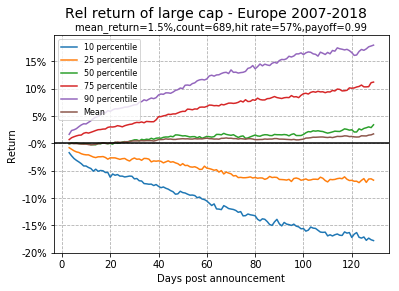

In [503]:
perf_chart_day(large_cap,"Days post announcement",
           "Return","Rel return of large cap - Europe 2007-2018",[6,4],
          [0.1,0.25,0.5,0.75,0.9])

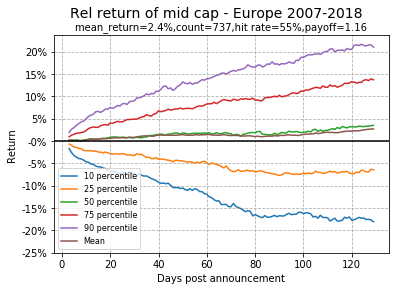

In [504]:
perf_chart_day(mid_cap,"Days post announcement",
           "Return","Rel return of mid cap - Europe 2007-2018",[6,4],
          [0.1,0.25,0.5,0.75,0.9])

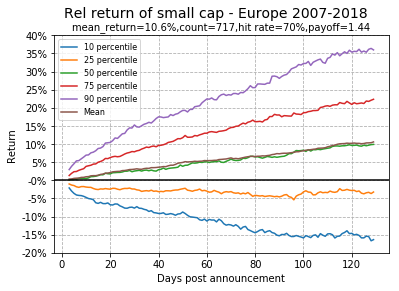

In [35]:
perf_chart_day(small_cap,"Days post announcement",
           "Return","Rel return of small cap - Europe 2007-2018",[6,4],
          [0.1,0.25,0.5,0.75,0.9])

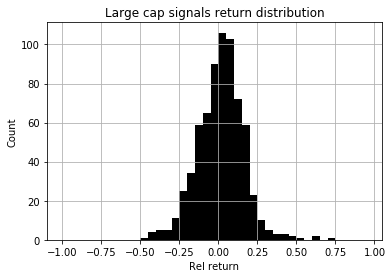

In [505]:
# large cap distribution
plt.figure(figsize=(6,4))
plt.hist(np.array(((1+large_cap).cumprod()-1).iloc[-1]),bins=np.arange(-1,1,0.05),color='k',density=False)
plt.title("Large cap signals return distribution")
plt.xlabel("Rel return")
plt.ylabel("Count")
plt.grid(True)

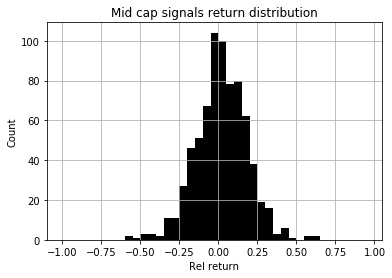

In [506]:
# mid cap distribution
plt.figure(figsize=(6,4))
plt.hist(np.array(((1+mid_cap).cumprod()-1).iloc[-1]),bins=np.arange(-1,1,0.05),color='k',density=False)
plt.title("Mid cap signals return distribution")
plt.xlabel("Rel return")
plt.ylabel("Count")
plt.grid(True)

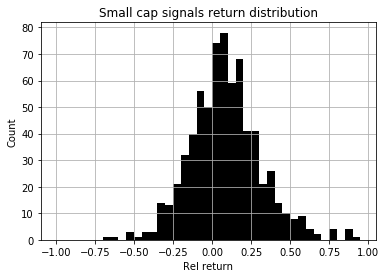

In [507]:
# smal cap distribution
plt.figure(figsize=(6,4))
plt.hist(np.array(((1+small_cap).cumprod()-1).iloc[-1]),bins=np.arange(-1,1,0.05),color='k',density=False)
plt.title("Small cap signals return distribution")
plt.xlabel("Rel return")
plt.ylabel("Count")
plt.grid(True)

## Let's add some stop loss

In [39]:
## utility function to get the vol from a column of signal_df
def signal_vol(signal_column,return_df,vol_lookback):
    signal_tuple=signal_column.name
    signal_series=abs_return.loc[signal_tuple[0]]
    location=signal_series.index.tolist().index(signal_tuple[1])
    vol_range=min(vol_lookback,len(signal_series[:location]))
    signal_vol=signal_series[location-vol_range-1:location].std()
    return signal_vol

In [508]:
# signal_df post stop loss filter 
def signal_filter_stop(signal_df,stop_level,return_df,vol_lookback):
    vol_row=signal_df.apply(lambda column:signal_vol(column,return_df,vol_lookback),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/vol_row
    signal_df_stop=signal_df[-(signal_cum_nmove.expanding().min().shift(1,axis=0)<stop_level)]
    return signal_df_stop

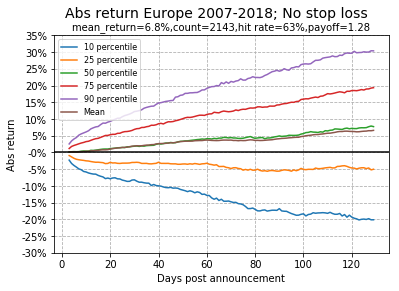

In [509]:
# No stop loss absolute
perf_chart_day(signal1_abs_df,"Days post announcement",
           "Abs return","Abs return Europe 2007-2018"+"; No stop loss",[6,4],
          [0.1,0.25,0.5,0.75,0.9])

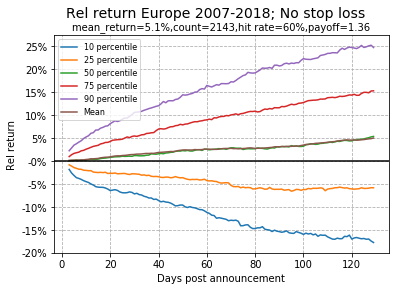

In [510]:
# No stop loss relative
perf_chart(signal1_rel_df,"Days post announcement",
           "Rel return","Rel return Europe 2007-2018"+"; No stop loss",[6,4],
          [0.1,0.25,0.5,0.75,0.9])

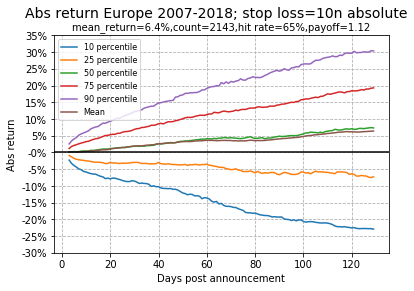

In [56]:
# Absolute stop loss
perf_chart_day(signal_filter_stop(signal1_abs_df,-10,abs_return,30),"Days post announcement",
           "Abs return","Abs return Europe 2007-2018"+"; stop loss="+"10n absolute",[6,4],
          [0.1,0.25,0.5,0.75,0.9])

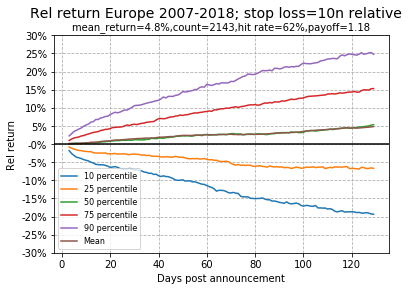

In [57]:
# Rel stop loss
perf_chart_day(signal_filter_stop(signal1_rel_df,-10,rel_return,30),"Days post announcement",
           "Rel return","Rel return Europe 2007-2018"+"; stop loss="+"10n relative",[6,4],
          [0.1,0.25,0.5,0.75,0.9])

## add absolute/relative high


In [45]:
## filter signal_df with abs/rel high
def signal_filter_high(signal_df,price_df,rolling_window):
    high_df=price_df.rolling(window=rolling_window,axis=1).max()==price_df
    high_evaluate=signal_df.apply(lambda x: (high_df.loc[x.name[0]].loc[x.name[1]]) or
                                  high_df.loc[x.name[0]].iloc[high_df.loc[x.name[0]].index.tolist().index(x.name[1])+1]) # either day 1 or day 2
    signal_filter_high=signal_df.loc[:,high_evaluate]
    return signal_filter_high

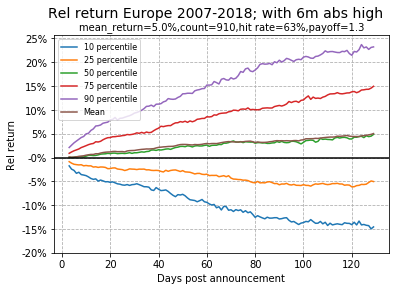

In [61]:
perf_chart_day(signal_filter_high(signal1_rel_df,price,120),"Days post announcement",
           "Rel return","Rel return Europe 2007-2018"+"; with 6m abs high",[6,4],
          [0.1,0.25,0.5,0.75,0.9])


## Add moving average

In [62]:
## filter signal_df with moving average
def signal_filter_MA(signal_df,price_df,MA_lookback):
    MA=price_df.rolling(MA_lookback,axis=1).mean()<price_df
    MA_evaluate=signal_df.apply(lambda x: MA.loc[x.name[0]].loc[x.name[1]])
    signal_filter_MA=signal_df.loc[:,MA_evaluate]
    return signal_filter_MA

In [63]:
signal1_MA50_abs_df=signal_filter_MA(signal1_abs_df,price,50)
signal1_MA50_rel_df=signal_filter_MA(signal1_rel_df,price,50)

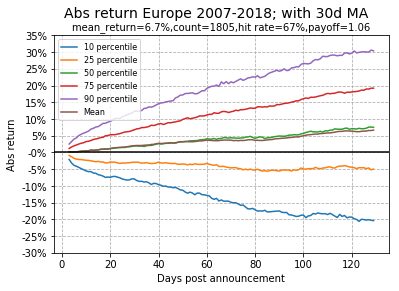

In [64]:
perf_chart_day(signal_filter_MA(signal1_abs_df,price,30),"Days post announcement",
           "Abs return","Abs return Europe 2007-2018"+"; with 30d MA",[6,4],
          [0.1,0.25,0.5,0.75,0.9])

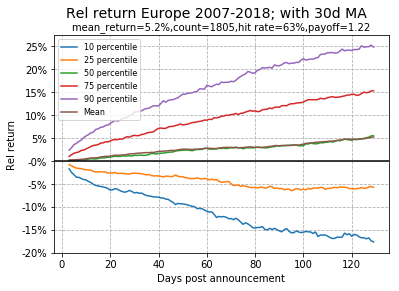

In [50]:
perf_chart_day(signal_filter_MA(signal1_rel_df,price,30),"Days post announcement",
           "Rel return","Rel return Europe 2007-2018"+"; with 30d MA",[6,4],
          [0.1,0.25,0.5,0.75,0.9])


## stop loss, moving average, high price together

In [51]:
signal1_rel_df_stop=signal_filter_stop(signal1_abs_df,-5,abs_return,30)
signal1_rel_df_stop_high=signal_filter_high(signal1_rel_df_stop,price,130)
signal1_rel_df_stop_high_MA=signal_filter_MA(signal1_rel_df_stop_high,price,50)

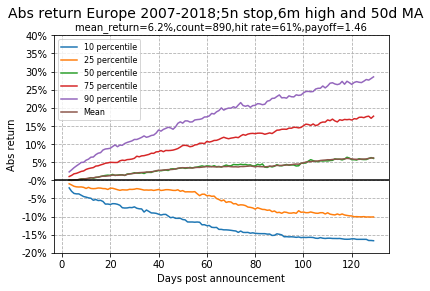

In [52]:
perf_chart_day(signal1_rel_df_stop_high_MA,"Days post announcement",
           "Abs return","Abs return Europe 2007-2018"+";5n stop,6m high and 50d MA",[6,4],
          [0.1,0.25,0.5,0.75,0.9])

# Build the account curve

In [477]:
# create a dictionary to have signal information (tuple) as keys and return data time series as values to make it easier to check
#;use actual dates rather than number of days post announcement
def signal1_dict_date(signal1_list,return_df,holding,earning,signal,entry):#if we hold them through next earning
    signal1_dict={}
    for s in signal1_list:
        return_series=return_df.loc[s[0]]
        if s[1] in return_series.index:          
            day0=return_series.index.tolist().index(s[1]) #index of day 0
            if s[2] is None:
                period=holding-entry
            elif earning is False:
                period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[2],"%d/%b/%Y"))-entry)
            elif (signal is False) & (s[3] is not None):
                period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[3],"%d/%b/%Y"))-entry)
            else:
                period=holding-entry
            target_series=return_series.iloc[day0+entry:day0+min(period+entry, len(return_series[day0:]))] # different from return_dict with number of dates post announcement
            target_series.name=(s[0])
            signal1_dict[s]=target_series
        else:
            pass          
    return signal1_dict

In [700]:
## signal df function adjusted to the actual dates
def signal1_df_date(signal1,signal1_next,return_df,holding,earning,signal,entry):
    signal1_list=signal1_stacking(signal1,signal1_next)
    signal1_dict=signal1_dict_date(signal1_list,return_df,holding,earning,signal,entry)
    my_df=pd.concat(signal1_dict,axis=1)
    my_df.index=[datetime.strptime(x,"%d/%b/%Y") for x in my_df.index.tolist()]
    signal1_df=my_df.sort_index()
    return signal1_df

In [796]:
signal1_rel_df_date=signal1_df_date(signal1,signal1_next,rel_return,130,True,False,3)

In [702]:
## grab volume data
volume=data_dict["Volume"]

## function to grab volume
def get_volume(signal_tuple,volume_df,date_df):
    ticker=signal_tuple[0]
    date_series=date_df.loc[ticker]
    volume_series=volume_df.loc[ticker]
    timestamp=pd.Timestamp(datetime.strptime(signal_tuple[1],"%d/%b/%Y").year,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").month,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").day)
    location=date_series.tolist().index(timestamp)
    return volume_series.iloc[location]

In [703]:
# create dataframe tracking the pnl accumulation, add liquidity constraint
def signal_pnl_date(signal_df_date,average_gross,capital,volume_df,date_df,liquidity_constraint):
    average_number=signal_df_date.count(axis=1).mean()
    average_size=average_gross/100/2/average_number
    size_row=signal_df_date.apply(lambda x: min(average_size,get_volume(x.name,volume_df,date_df)*liquidity_constraint/capital),axis=0)
    signal_pnl_date=((1+signal_df_date).cumprod()-1)*size_row
    return signal_pnl_date

In [797]:
signal1_rel_pnl_date=signal_pnl_date(signal1_rel_df_date,100,100,volume,data_dict["Date"],0.1)

In [696]:
# Performance analytics
# 1. trading analytics
def trading_analytics_date(signal_pnl_date):
    ind_return=((1+signal_pnl_date).cumprod()-1).ffill().iloc[-1].dropna()
    signal_count=len(ind_return)
    
    if signal_count==0:
        return None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        
        signal_price_date=signal_pnl_date.ffill().sum(axis=1)+1
        ann_vol=np.std(signal_price_date.diff()/signal_price_date.shift(1))*(260**0.5)
        ann_ret=np.mean(signal_price_date.diff()/signal_price_date.shift(1))*260
        ann_sharpe=ann_ret/ann_vol
        return signal_count,hit_rate,payoff_ratio,ann_ret,ann_vol,ann_sharpe

In [794]:
# 2. aggregate abs/rel performance over time
def perf_chart_date(signal_pnl_date,xlabel,ylabel,title,figsize):
    account_curve=signal_pnl_date.ffill().sum(axis=1)
    
    ax=account_curve.plot(figsize=figsize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    vals=ax.get_yticks()
    start=vals[0]
    end=vals[-1]
    ax.set_yticks(np.arange(start,end,0.05))  
    adj_vals=ax.get_yticks()
    ax.set_yticklabels(["{:.0%}".format(x) for x in adj_vals])
    
    count,hit,payoff,ret,vol,sharpe=trading_analytics_date(signal_pnl_date)
    
    plt.title("\n".join(wrap('count='+str(count)+
              ',hit_rate='+str("{:.0%}".format(hit))+
              ',payoff='+str(round(payoff,2))+
              ',annualised_return='+str("{:.1%}".format(ret))+
              ',annualised_vol='+str("{:.1%}".format(vol))+
              ',sharpe='+str(round(sharpe,2)))),fontsize=10)
    
    plt.suptitle(title,y=1.05,fontsize=16)
    plt.grid(linestyle='dashed')
    plt.axhline(y=0,color='k')

    plt.show()


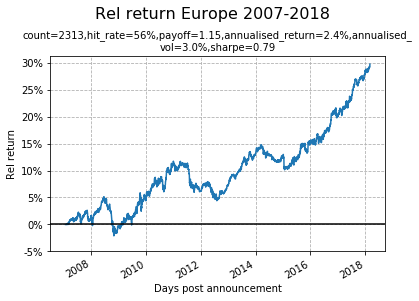

In [798]:
perf_chart_date(signal1_rel_pnl_date,"Days post announcement",
           "Rel return","Rel return Europe 2007-2018"+"",[6,4])